# Одномерная минимизация криловлинейной psf.
* поиск дальней точки через кепстр
* начальное приближение - полный перебор на срединном перпендикуляре
* уточнение градиентным спуском по очереди
<img src="pic/minimization_ill.png">

Время работы: 6:24

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
from skimage.restoration import richardson_lucy
from skimage.measure import compare_psnr

from scipy.signal import convolve2d
from scipy.optimize import minimize

from functools import partial
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *

In [2]:
prefix = "pic/one-dim-iterated-astro"

In [3]:
astro = color.rgb2gray(data.astronaut())
liftingbody = astro#img_as_float(io.imread('liftingbody.png'))
iterations = 30

In [4]:
sz = 21
deg = 1.15
points_real = [(deg-1)*sz//deg-1, sz//deg, 3*sz//2-1, sz-1]
print(points_real)
psf_bezier = bezier_psf2(points_real)

[1.0, 18.0, 30, 20]


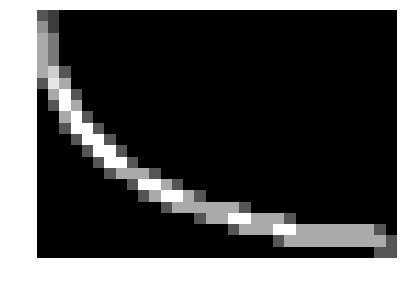

In [5]:
show_and_save_image(image=psf_bezier,
                    #plot_arr=[[0,0,'ro'],
                     #         [points_real[0], points_real[1], 'ro'],
                     #         [points_real[2], points_real[3], 'ro']],
                   fname="{0}-curved-psf-real.png".format(prefix))

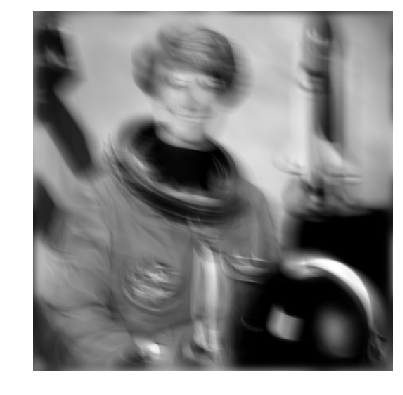

In [6]:
lifting_bezier_blurred = convolve2d(liftingbody, psf_bezier, 'same', 'symm')
lifting_bezier_blurred = edgetaper(lifting_bezier_blurred, gkern2(45, 7))
show_and_save_image(lifting_bezier_blurred, fname="{0}-blurred-data.png".format(prefix))

In [7]:
s_n, S_find = find_noise(lifting_bezier_blurred)
s_n

2.2091946999715183e-05

In [8]:
N,M = lifting_bezier_blurred.shape
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_bezier_blurred))))
K_shift = np.fft.fftshift(K)

n, m, = K_shift.shape
r, c = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
x0_2 = np.array([c - m//2, r - n//2])

if x0_2[0]<0:
    x0_2 = -x0_2
x0_1 = x0_2/2# + np.array([4,-4])
x0 = np.concatenate((x0_1, x0_2))
print(x0)

[ 1. -1.  2. -2.]


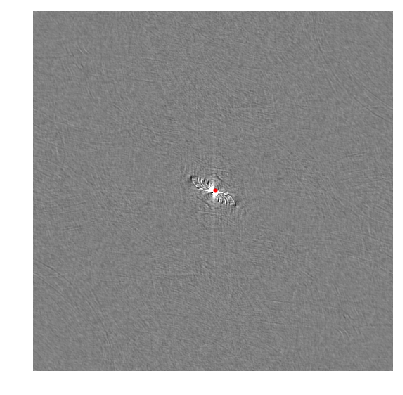

In [9]:
show_and_save_image(np.clip(np.real(K_shift),-1,1),
                    plot_arr=[[c, r, 'r.']],
                    fname="{0}-kepstr.png".format(prefix))

In [10]:
N,M = lifting_bezier_blurred.shape
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_bezier_blurred))))
K_shift = np.fft.fftshift(K)

n, m, = K_shift.shape

mask_sigma = 8
XX, YY = np.meshgrid(range(m), range(n))
gauss_mask = np.exp(-((XX-m//2)**2 + (YY-n//2)**2) / (2*mask_sigma**2))
K_shift -= K_shift*gauss_mask

r, c = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
x0_2 = np.array([c - m//2, r - n//2])

if x0_2[0]<0:
    x0_2 = -x0_2
x0_1 = x0_2/2# + np.array([4,-4])
x0 = np.concatenate((x0_1, x0_2))
print(x0)

[15.5 10.  31.  20. ]


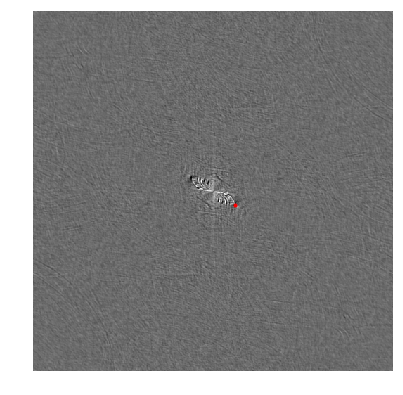

In [11]:
show_and_save_image(np.clip(np.real(K_shift),-1,1),
                    plot_arr=[[c, r, 'r.']],
                    fname="{0}-kepstr-with-guass.png".format(prefix))

In [12]:
x1_vec = np.array([x0_2[1], -x0_2[0]])
x1_vec = x1_vec / vec_len(x1_vec)
print(x1_vec)

[ 0.54212687 -0.84029665]


In [13]:
cost_fun = partial(funcToMinimizeCurvedNormal, xy2=x0_2, I_blurred=lifting_bezier_blurred, 
                   iterations=iterations, eps=1e-5, dampar=s_n)

In [14]:
L = vec_len(x0_2)
distances = np.linspace(-L/2, L/2, 30)
best_val = 1e9 #+inf
best_dist = 0
for dist in distances:
    val = cost_fun(dist)
    if val < best_val:
        best_dist = dist
        best_val = val

In [15]:
best_dist, best_val

(-12.085223040284054, 0.0003280858053436818)

In [16]:
point2 = second_point(x0_2, best_dist)
points_found = np.concatenate((point2, x0_2))
print(points_found)

[ 8.94827586 20.15517241 31.         20.        ]


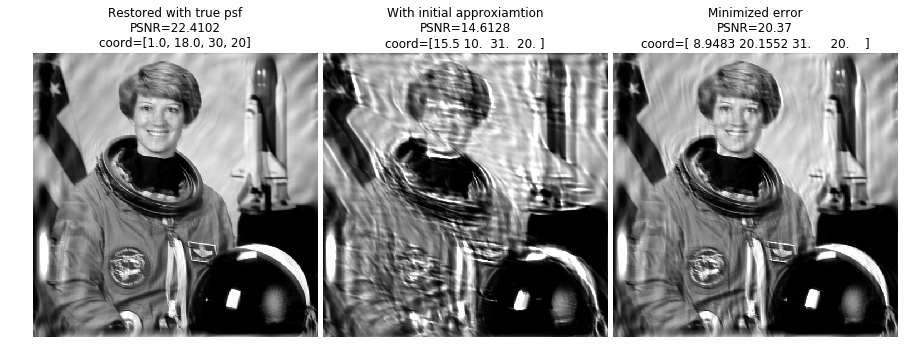

In [17]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, 
                                     dampar=s_n)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

#points_found = res_my_grad2['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(4), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(4), x0.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(4), points_found.round(4))],
             savefig='{0}.png'.format(prefix))

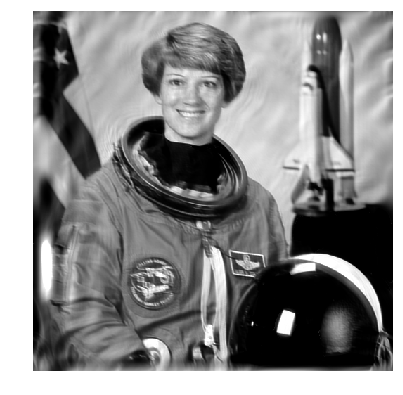

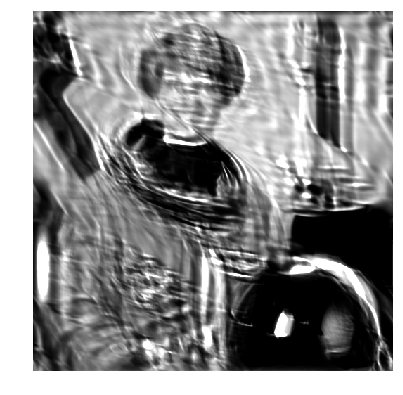

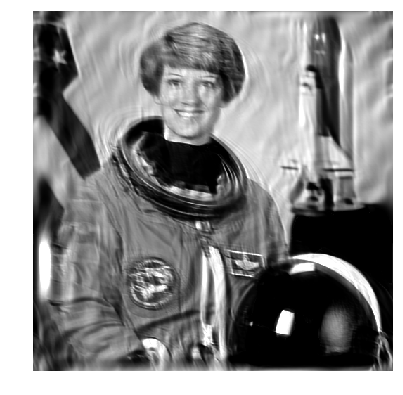

In [18]:
for image, title in [[deconv_orig['image'], '{0}-restored-true-psf.png'.format(prefix)],
                     [deconv_init['image'], '{0}-restored-initial-approx.png'.format(prefix)],
                     [deconv_found['image'], '{0}-restored-second-approx.png'.format(prefix)]]:
    show_and_save_image(image, fname=title)

In [19]:
x1_1 = point2
x1_2 = x0_2
for it in range(4):
    changed = False
    # move third point
    cost_fun1 = partial(funcToMinimizeCurved3, xy1=x1_1, I_blurred=lifting_bezier_blurred, 
                        iterations=iterations, eps=1e-5, dampar=s_n)
    res1 = minimize_grad(cost_fun1, x0=x1_2, alpha=100, maxiter=5)
    if not (x1_2 == res1.x).all():
        changed = True
    x1_2 = res1.x
    print(x1_1, x1_2)
    cost_fun2 = partial(funcToMinimizeCurved2, xy2=x1_2, I_blurred=lifting_bezier_blurred, 
                        iterations=iterations, eps=1e-5, dampar=s_n)
    res2 = minimize_grad(cost_fun2, x0=x1_1, alpha=100, maxiter=5)
    if not (x1_1 == res2.x).all():
        changed = True
    x1_1 = res2.x
    print(x1_1, x1_2)
    if not changed:
        break

[ 8.94827586 20.15517241] [31.00180885 19.99779254]
[ 8.94827586 20.15517241] [31.00180885 19.99779254]
[ 8.94827586 20.15517241] [31.00180885 19.99779254]
[ 8.94827586 20.15517241] [31.00180885 19.99779254]


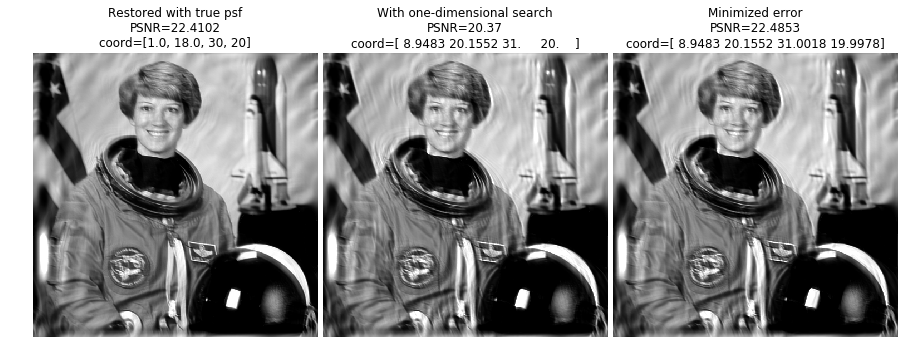

In [20]:
#deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, 
#                                     dampar=s_n)
#psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(points_found)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

points_found2 = np.concatenate((x1_1, x1_2))
psf_found = bezier_psf2(points_found2)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(4), points_real), 
                     'With one-dimensional search\nPSNR={0}\ncoord={1}'.format(psnr_init.round(4), points_found.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(4), points_found2.round(4))],
             savefig='{0}-thiner.png'.format(prefix))

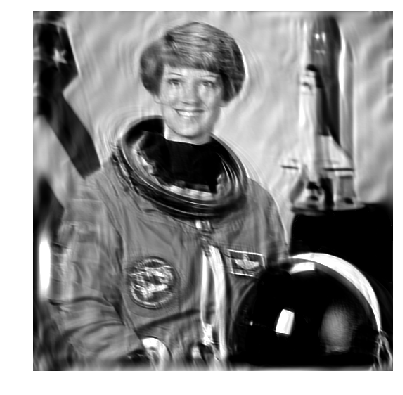

In [21]:
for image, title in [[deconv_found['image'], '{0}-restored-final.png'.format(prefix)]]:
    show_and_save_image(image, fname=title)

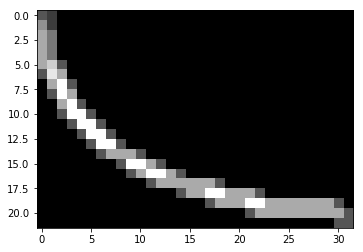

In [22]:
plt.imshow(bezier_psf2(points_real))
plt.show()

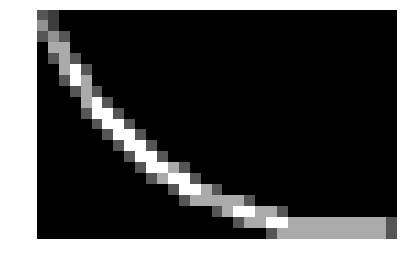

In [23]:
show_and_save_image(psf_found,
                    #plot_arr=[[points_found2[0], points_found2[1], 'ro'],
                    #          [points_found[0], points_found[1], 'go'],
                    #          [points_found[2], points_found[3], 'go']],
                    fname="{0}-curved-psf-found.png".format(prefix))

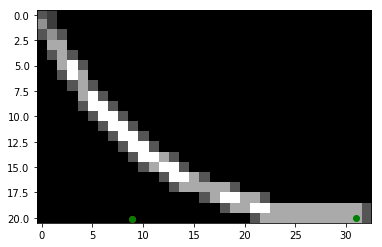

In [24]:
plt.imshow(psf_found)
plt.plot(points_found2[0], points_found2[1], 'ro')
plt.plot(points_found[0], points_found[1], 'go')
plt.plot(points_found[2], points_found[3], 'go')
plt.show()